## Find the last index of lambda at which Hessian initiation starts to fail
by examining the logging of lambda tuning

In [1]:
!ls

analyze_outcome_10types.ipynb tuning_result
log_10types.txt


In [2]:
import re
import pandas as pd

def split_and_save_log_file(file_path):
    # Read the contents of the uploaded file
    with open(file_path, 'r') as file:
        log_content = file.read()

    # Splitting the log file into parts for each cell type
    # The pattern to look for is "Starting job for <celltype>"
    celltype_sections = re.split(r"Starting job for ", log_content)

    # The first split will be an empty string or a header, so it should be removed
    celltype_sections = celltype_sections[1:]

    # Process each section
    for section in celltype_sections:
        # Extracting the cell type name (first line of each section)
        celltype_name = section.split('\n', 1)[0].strip()

        # File path for the output file
        output_file_path = f'log_{celltype_name}.txt'

        # Writing the section to the file
        with open(output_file_path, 'w') as file:
            file.write(section)

        print(f"File for '{celltype_name}' saved as: {output_file_path}")

# Example usage
file_path = 'log_10types.txt'  # Replace with your log file path
split_and_save_log_file(file_path)


File for 'ASDC' saved as: log_ASDC.txt
File for 'B_intermediate' saved as: log_B_intermediate.txt
File for 'B_naive' saved as: log_B_naive.txt
File for 'CD14_Mono' saved as: log_CD14_Mono.txt
File for 'CD4_Naive' saved as: log_CD4_Naive.txt
File for 'CD4_Proliferating' saved as: log_CD4_Proliferating.txt
File for 'CD4_TEM' saved as: log_CD4_TEM.txt
File for 'CD8_Naive' saved as: log_CD8_Naive.txt
File for 'CD8_Proliferating' saved as: log_CD8_Proliferating.txt
File for 'CD8_TCM' saved as: log_CD8_TCM.txt


In [3]:
def parse_celltype_log(filepath):
    with open(filepath, 'r') as file:
        file_content = file.read()

    # Regular expressions to capture the required information
    celltype_pattern = r"Starting job for (\w+)"
    lambda_pattern = r"Lambda:\s+([\d.]+)"
    outcome_patterns = [
        r"Hessian initialization fail, gradient diff = \d",
        r"Hessian approximation fail, yTs = 0",
        r"OWL-QN did not convergence",
        r"Convergence with loss threshold"
    ]

    # Split the content into sections
    sections = re.split(r"=+\n", file_content)

    # Adjusting the approach to extract all outcomes for 25 lambdas, regardless of the cell type.
    # Since the user is specifically interested in 25 lambda values, we will ensure to capture 25 distinct lambdas.

    # Initialize a new list to hold the extracted data
    all_data = []

    # Process each section to extract lambda and outcome, regardless of celltype
    for section in sections:
        lambda_match = re.search(lambda_pattern, section)
        outcome_match = None
        for outcome_pattern in outcome_patterns:
            outcome_match = re.search(outcome_pattern, section)
            if outcome_match:
                break

        # If matches are found for lambda and outcome, add to the data list
        if lambda_match and outcome_match:
            all_data.append({
                'lambda': float(lambda_match.group(1)),
                'outcome': outcome_match.group(0)
            })

    # Convert the new data list to a DataFrame
    all_df = pd.DataFrame(all_data, columns=['lambda', 'outcome'])

    # Ensure only distinct lambdas are present, and limit to 25 if there are more
    unique_lambdas_df = all_df.drop_duplicates(subset=['lambda']).head(25)

    # Sorting the dataframe by lambda values in ascending order
    outcome_df = unique_lambdas_df.sort_values(by='lambda')
    outcome_df.reset_index(drop=True, inplace=True)

    return outcome_df

In [4]:
import os

outcome_dict = {}
for file in os.listdir():
    if file.startswith('log_'):
        if file == 'log_10types.txt':
            continue
        celltype_name = file.replace('log_', '').replace('.txt', '')
        outcome_df = parse_celltype_log(file)
        outcome_dict[celltype_name] = outcome_df

In [9]:
cut_idx_dict = {}

for celltype in outcome_dict.keys():
    print(f"Cell type: {celltype}")
    print(outcome_dict[celltype])
    
    for out in outcome_dict[celltype]['outcome']:
        if out != 'OWL-QN did not convergence' and out != 'Convergence with loss threshold':
            cut_idx = outcome_dict[celltype][outcome_dict[celltype]['outcome'] == out].index[0]
            cut_idx_dict[celltype] = cut_idx
            print(f"Cut index: {cut_idx}")
            break
            
    print('====================')
    print()


Cell type: CD8_Naive
      lambda                                         outcome
0   0.000100                      OWL-QN did not convergence
1   0.000147                      OWL-QN did not convergence
2   0.000215                      OWL-QN did not convergence
3   0.000316                      OWL-QN did not convergence
4   0.000464                      OWL-QN did not convergence
5   0.000681                      OWL-QN did not convergence
6   0.001000                      OWL-QN did not convergence
7   0.001468                      OWL-QN did not convergence
8   0.002154                      OWL-QN did not convergence
9   0.003162                      OWL-QN did not convergence
10  0.004642                      OWL-QN did not convergence
11  0.006813                      OWL-QN did not convergence
12  0.010000                      OWL-QN did not convergence
13  0.014678                      OWL-QN did not convergence
14  0.021544             Hessian approximation fail, yTs = 0
15 

In [10]:
cut_idx_dict

{'CD8_Naive': 14,
 'CD14_Mono': 15,
 'CD4_Naive': 11,
 'CD4_Proliferating': 7,
 'CD8_TCM': 7,
 'CD8_Proliferating': 7,
 'B_intermediate': 11,
 'CD4_TEM': 13,
 'ASDC': 8,
 'B_naive': 7}

In [11]:
outcome_dict.keys()

dict_keys(['CD8_Naive', 'CD14_Mono', 'CD4_Naive', 'CD4_Proliferating', 'CD8_TCM', 'CD8_Proliferating', 'B_intermediate', 'CD4_TEM', 'ASDC', 'B_naive'])

## Ignore section lambda decision

In [12]:
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
from ADlasso2 import AD2_w_utils_loss as ad

In [13]:
# Plot lambda vs. prevalence and lambda vs. loss
# also mark the optimal lambda and the lambda that prevalence start to become 0

def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, savepath=''):
    fig, ax1 = plt.subplots(figsize = (8, 5))
    ax2 = ax1.twinx()

    line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
    line2, = ax2.plot(np.exp(tuning['log_lambda_range']), 100*tuning['Prevalence'], marker='o', color='orange')
    ax1.set(xscale="log")
    plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
    print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
    plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
    ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
    ax1.set_ylabel("Loss"); ax2.set_ylabel("Prevalence (%)")
    # ax2.set_ylim(0, 120)
    ax1.set_title(f'{celltype} lambda decision')
    plt.legend(handles=[line1, line2], labels=['BCE loss', 'Prevalence'], loc='upper left')

    if savepath:
        plt.savefig(savepath, dpi=300)

In [15]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level2_loss_converge/loss_lambda_tuning_10types')

def ignore_section_lambda_decision(celltype, cut_idx):
    print('====================')
    print(f'Cell type: {celltype}')
    with open(f'./tuning_result/{celltype}_tuning.json') as f:
        tuning = json.load(f)
        for k in tuning.keys():
            tuning[k] = np.array(tuning[k])
    
    trimmed_tuning = {}
    for k in tuning.keys():
        trimmed_tuning[k] = tuning[k][:cut_idx]
    
    # Lambda decision from trimmed tuning result
    opt_lmbd, fig = ad.lambda_decision(trimmed_tuning, k=2, savepath=f'./lambda_decision/{celltype}_lambda_decision.png')
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, savepath=f'./lambda_decision/{celltype}_lambda_decision_all.png')
    
    return opt_lmbd, feature_no_celltype

Cell type: CD8_Naive
Optimal lambda: 0.0021544346900318864
Feature no: 32
Cut: 0.02154434690031885
Cell type: CD14_Mono
Optimal lambda: 0.004641588833612781
Feature no: 19
Cut: 0.031622776601683826
Cell type: CD4_Naive
Optimal lambda: 0.0004641588833612784
Feature no: 256
Cut: 0.006812920690579619
Cell type: CD4_Proliferating
Optimal lambda: 0.00010000000000000009
Feature no: 3773
Cut: 0.0014677992676220707
Cell type: CD8_TCM
Optimal lambda: 0.0002154434690031884
Feature no: 195
Cut: 0.0014677992676220707
Cell type: CD8_Proliferating
Optimal lambda: 0.0006812920690579617
Feature no: 603
Cut: 0.0014677992676220707
Cell type: B_intermediate
Optimal lambda: 0.0010000000000000002
Feature no: 15
Cut: 0.006812920690579619
Cell type: CD4_TEM
Optimal lambda: 0.0014677992676220707
Feature no: 19
Cut: 0.014677992676220709
Cell type: ASDC
Optimal lambda: 0.0003162277660168384
Feature no: 2079
Cut: 0.0021544346900318864
Cell type: B_naive
Optimal lambda: 0.0004641588833612784
Feature no: 23
Cut: 0

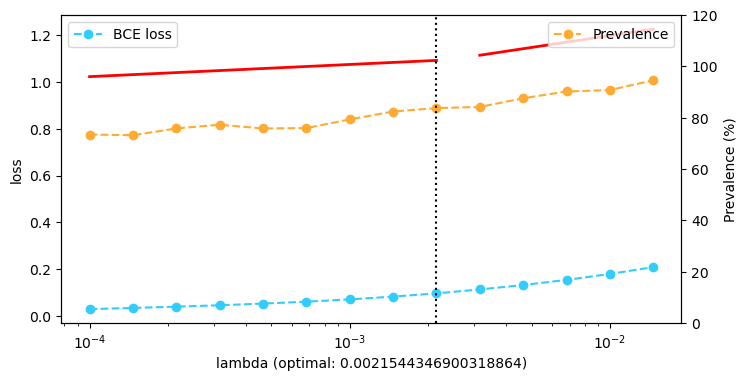

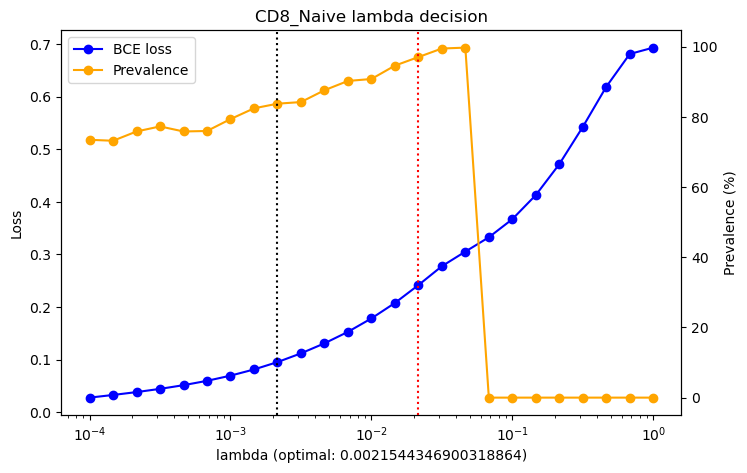

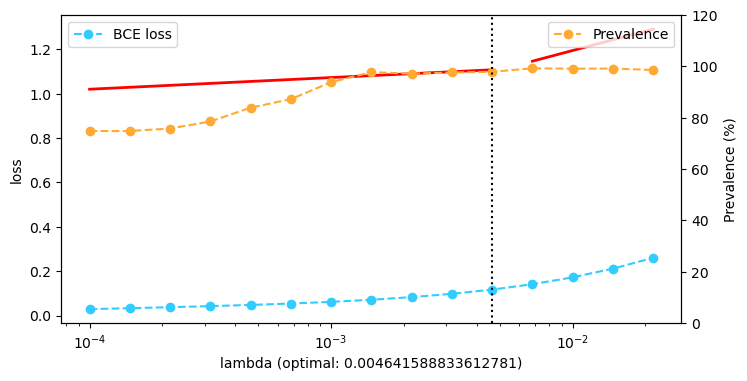

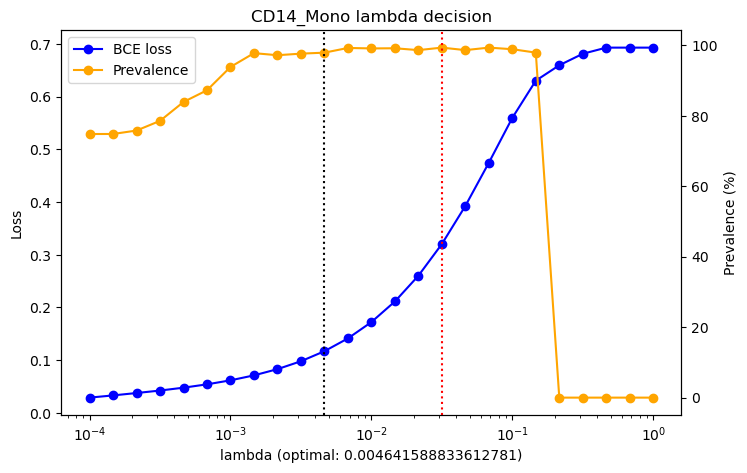

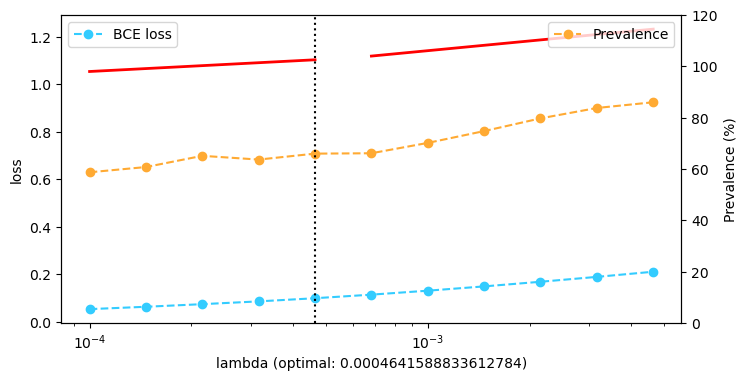

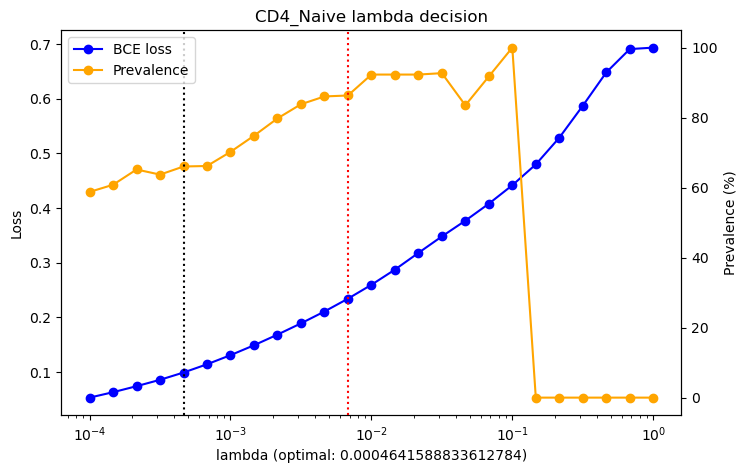

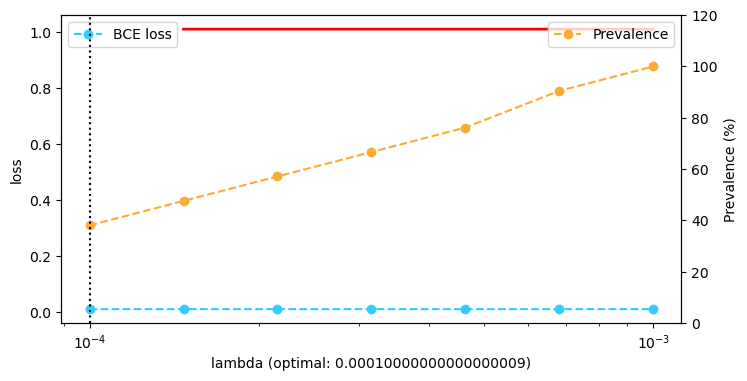

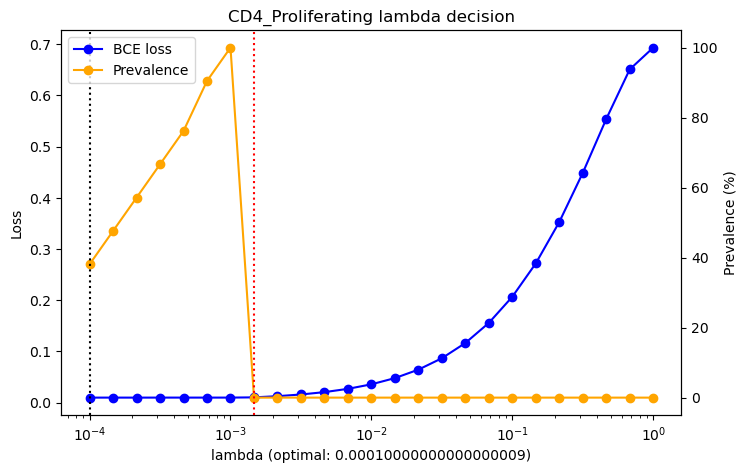

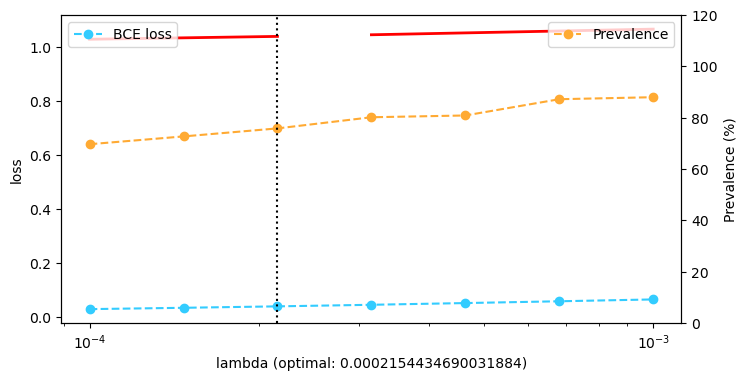

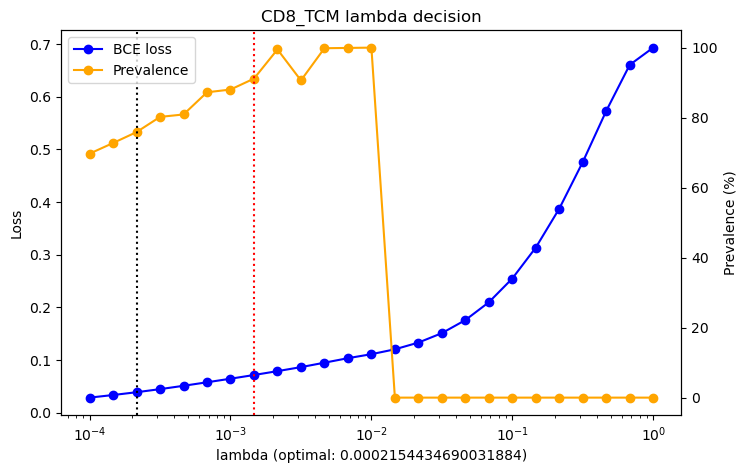

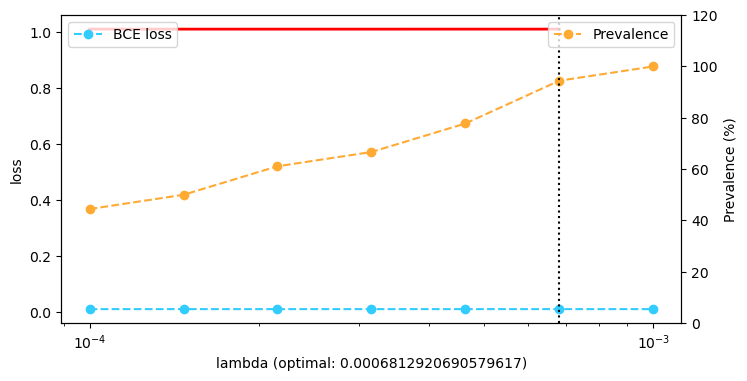

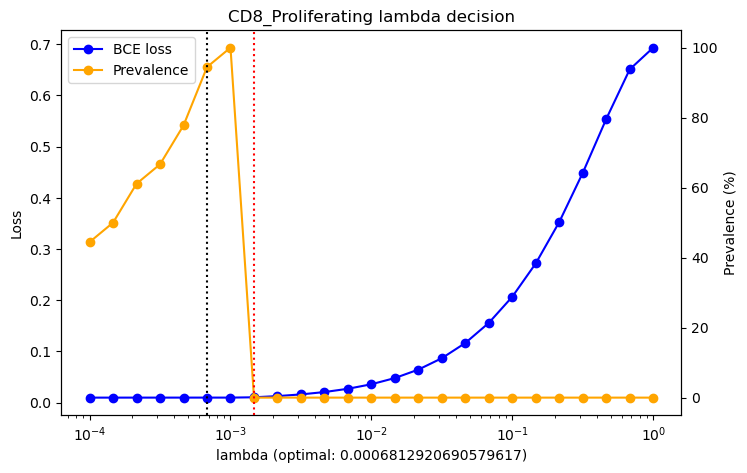

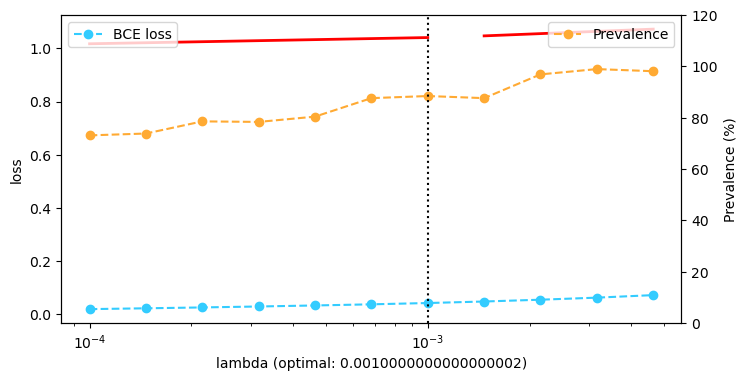

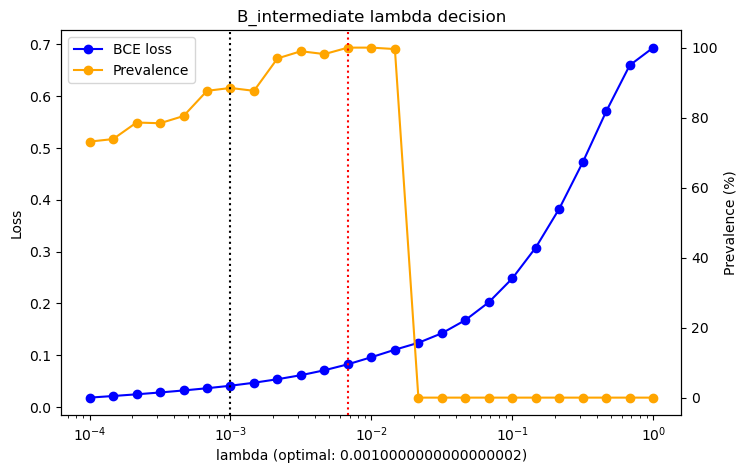

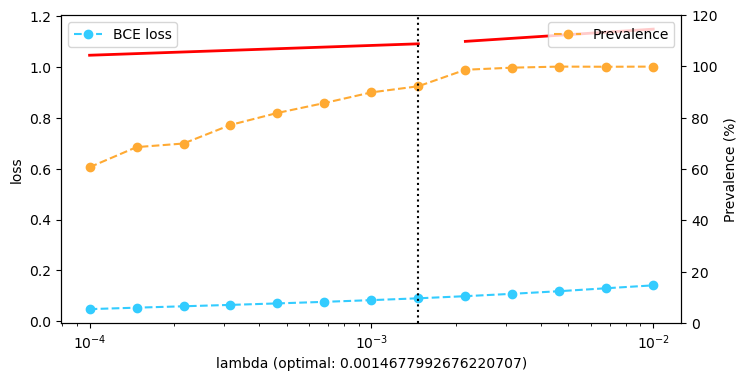

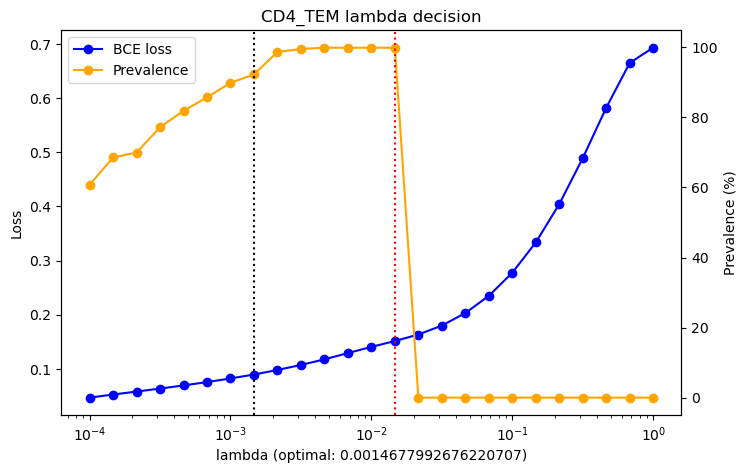

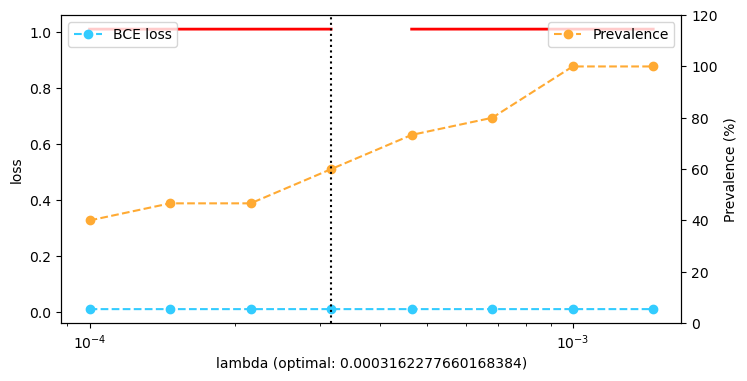

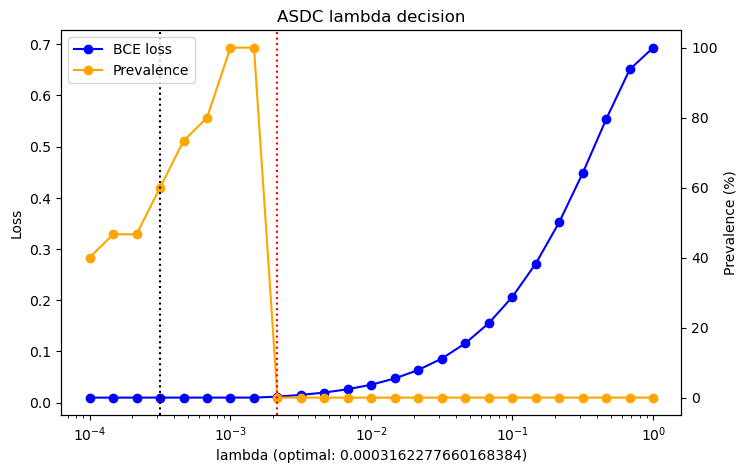

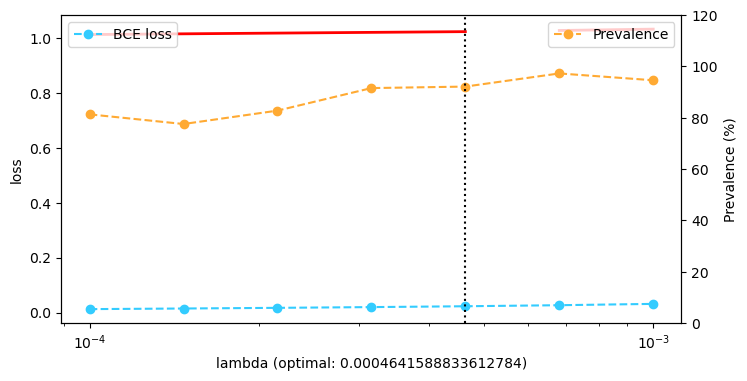

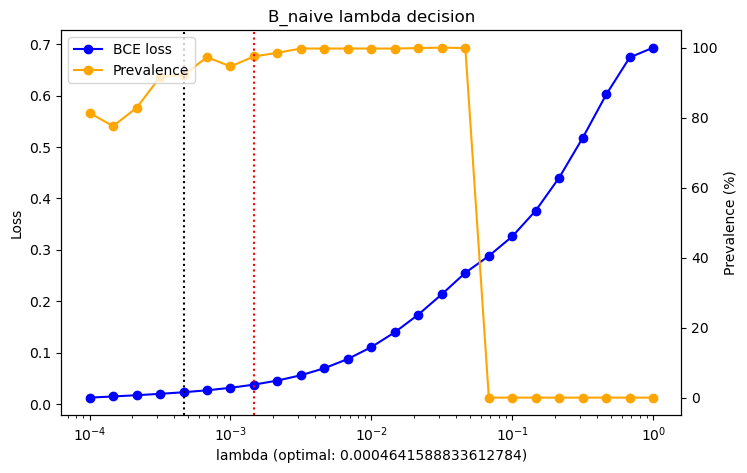

In [16]:
opt_lmbd_dict = {}
feature_no_dict = {}

for celltype in cut_idx_dict.keys():
    opt_lmbd, feature_no = ignore_section_lambda_decision(celltype, cut_idx_dict[celltype])
    opt_lmbd_dict[celltype] = opt_lmbd
    feature_no_dict[celltype] = feature_no
    

In [17]:
opt_lmbd_dict

{'CD8_Naive': 0.0021544346900318864,
 'CD14_Mono': 0.004641588833612781,
 'CD4_Naive': 0.0004641588833612784,
 'CD4_Proliferating': 0.00010000000000000009,
 'CD8_TCM': 0.0002154434690031884,
 'CD8_Proliferating': 0.0006812920690579617,
 'B_intermediate': 0.0010000000000000002,
 'CD4_TEM': 0.0014677992676220707,
 'ASDC': 0.0003162277660168384,
 'B_naive': 0.0004641588833612784}

In [18]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level2_loss_converge/loss_lambda_tuning_10types


In [19]:
with open('loss_optimal_lambda_10types.json', 'w') as f:
    json.dump(opt_lmbd_dict, f)

## Count features at optimal lambda

In [20]:
feature_no_dict

{'CD8_Naive': 32,
 'CD14_Mono': 19,
 'CD4_Naive': 256,
 'CD4_Proliferating': 3773,
 'CD8_TCM': 195,
 'CD8_Proliferating': 603,
 'B_intermediate': 15,
 'CD4_TEM': 19,
 'ASDC': 2079,
 'B_naive': 23}

In [21]:
feature_no_5types = {'CD4_TCM': 76, 'B_memory': 25, 'NK': 17, 'CD16_Mono': 13, 'CD4_CTL': 70}
feature_no_dict.update(feature_no_5types)
feature_no_dict


{'CD8_Naive': 32,
 'CD14_Mono': 19,
 'CD4_Naive': 256,
 'CD4_Proliferating': 3773,
 'CD8_TCM': 195,
 'CD8_Proliferating': 603,
 'B_intermediate': 15,
 'CD4_TEM': 19,
 'ASDC': 2079,
 'B_naive': 23,
 'CD4_TCM': 76,
 'B_memory': 25,
 'NK': 17,
 'CD16_Mono': 13,
 'CD4_CTL': 70}

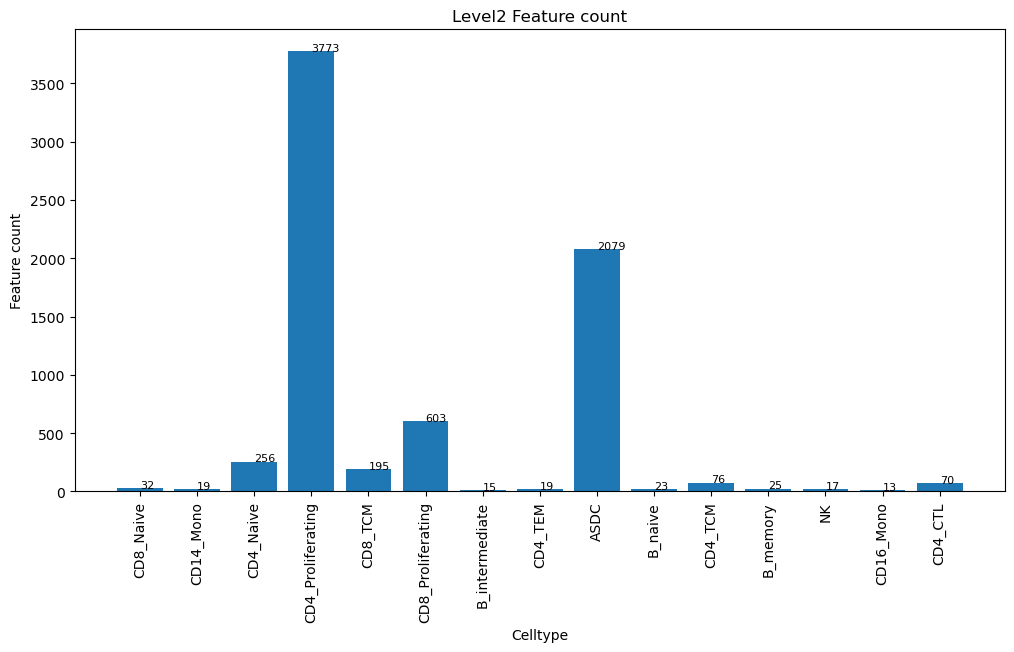

In [24]:
# plt.bar(feature_no_df['Celltype'], feature_no_df['Features'])
plt.figure(figsize=(12, 6))
plt.bar(feature_no_dict.keys(), feature_no_dict.values())

# Add the values to each bar
for i, v in feature_no_dict.items():
    plt.text(i, v, str(v), fontsize=8)

# Set the x-axis label
plt.xlabel('Celltype')
plt.xticks(rotation=90)

# Set the y-axis label
plt.ylabel('Feature count')

# Set y-axis to log scale
# plt.yscale('log')

plt.title('Level2 Feature count')
# Show the plot
plt.savefig('L2_loss_feature_count.png', dpi=300)
plt.show()